In [1]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-08-16 15:15:50.865487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 15:15:51.031247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 15:15:51.085346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 15:15:51.416811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 15:15:53.672058: W tensorflow/compiler/tf2

A gradient tape only serves to compute one gradient at a time.

In [15]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  velocity = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(velocity, time)
print(acceleration)

tf.Tensor(9.8, shape=(), dtype=float32)


# Linear classifier

## Generating some data

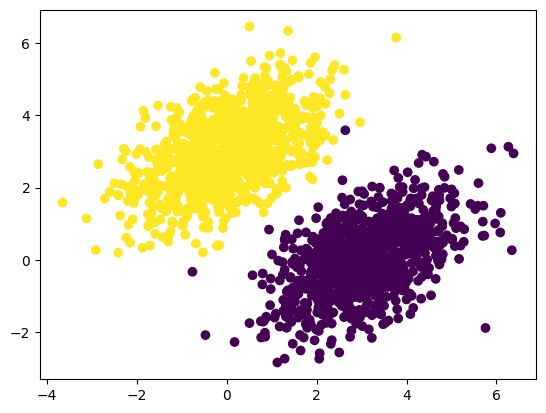

In [38]:
num_samples_per_class = 1000

rng = np.random.default_rng()

colors = ['red', 'blue']

points = np.vstack(
  (
    rng.multivariate_normal(mean=[0, 3], cov=[[1., 0.5], [0.5, 1.]], size=num_samples_per_class),  # Each point's shape is defined by "mean" and "cov" parameters; thus "size" defines the number of points
    rng.multivariate_normal(mean=[3, 0], cov=[[1., 0.5], [0.5, 1.]], size=num_samples_per_class),
  )
).astype(np.float32)
# Reflex: treat labels as a matrix of size (nb_samples, 1)
# Thus later we'll need to index this correctly
labels = np.vstack((np.ones((num_samples_per_class, 1)), np.zeros((num_samples_per_class, 1))))

plt.scatter(points[:, 0], points[:, 1], c=labels[:, 0])

In [39]:
timestamp = int(time.time())

train_data = points.copy()
train_labels = labels.copy()
random.Random(timestamp).shuffle(train_data)
random.Random(timestamp).shuffle(train_labels)

train_data.dtype

dtype('float32')

## Running a linear classifier

In [46]:
input_dim = 2
output_dim = 1

epochs = 40
learning_rate = 0.1

W = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
B = tf.Variable(tf.random.uniform(shape=(output_dim,)))

losses = []

def model(inputs):
  return tf.matmul(inputs, W) + B

def square_loss(targets, predictions):
  return tf.reduce_mean(
      tf.square(targets - predictions)
    )

def training_step(x, y, learning_rate):
  # W and B are in "model" so we must include the prediction inside the tape for it to follow our operations
  with tf.GradientTape() as tape:
    y_pred = model(x)
    # The loss of all the inputs is the mean of all squared errors on individual inputs
    loss = square_loss(y, y_pred)
    losses.append(loss)
  gradient_loss_wrt_w, gradient_loss_wrt_b = tape.gradient(loss, [W, B])
  W.assign_sub(gradient_loss_wrt_w * learning_rate)
  B.assign_sub(gradient_loss_wrt_b * learning_rate)
  
  
def train(x, y):

  for _ in range(epochs):
    training_step(x, y, learning_rate)

# We practice here batch training instead of mini-batch
train(train_data, train_labels)

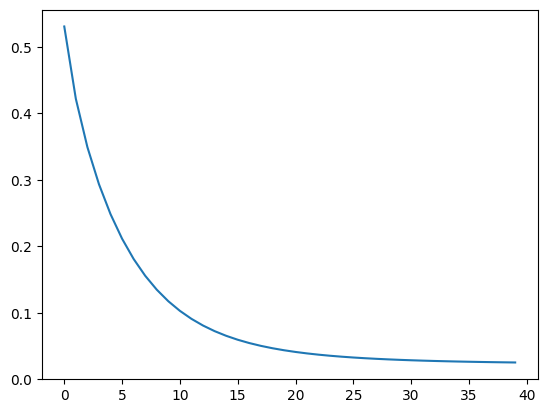

In [47]:
plt.plot(range(epochs), losses)

To visualize model's predictions, we calculate all the outputs and apply a threshold.

Thus the separation line is: W1.x + W2.y + b = 0.5 <=> y = (0.5 - b - W1.x)/W2

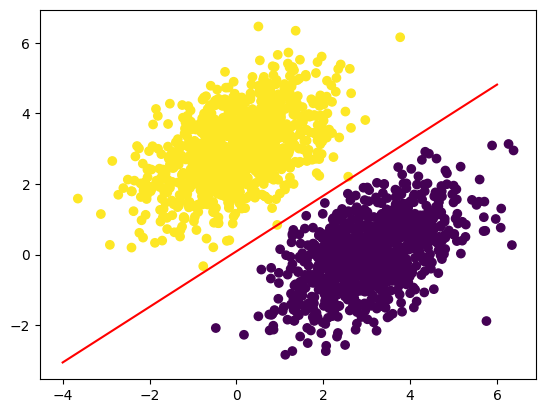

In [54]:
x = np.linspace(-4, 6, 150)
y = (0.5 - B - W[0]*x) / W[1]

result = np.where(model(points) > 0.5, 1, 0)
plt.plot(x, y, color='red')
plt.scatter(points[:, 0], points[:, 1], c=result[:, 0])